This interactive notebook guides you through the implementation, training, and analysis of a GNN-based model used for predicting the experimental hydration free energy of small molecules in water. The dataset used for training and validation purposes is [FreeSolv](https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv) accessible through [MoleculeNet](https://moleculenet.org), a widely recognized benchmark for molecular machine learning developed by the [Pande Group](https://www.pandelab.org) at Stanford.

The model is a message-passing neural network (MPNN) that learns embeddings for various atom types found in the molecules within the dataset. These atom types were derived by parameterizing each molecule in the dataset using the [GAFF2](https://ambermd.org/AmberModels_organic.php) force field (utilizing [acpype](https://github.com/alanwilter/acpype)) and collecting all unique atom types assigned according to the force field across all molecules.

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from utils.molecule import Molecule
from utils.dataset import GraphDataset, collate_graphs
from utils.helper import train_and_validate, plot_history

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 12})

Before diving in, we'll need to obtain the FreeSolv dataset and preprocess it, which involves parameterizing each molecule with GAFF2 and saving the necessary output. This step has already been completed, and you can find the processed data in the `solvation_energies.csv` file located in the same directory as this interactive notebook. If you prefer to download and preprocess the raw data yourself, you can uncomment and run the cell below, but be aware that this process may take up to an hour depending on your machine's specifications. Additionally, you can examine the `preprocess.sh` script located at `./utils/preprocess` to gain a better understanding of how the data preparation was performed.

In [ ]:
# # Uncomment and run this cell to download and preprocess the raw data.

# !wget -O solvation_energies_raw.csv -q https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv
# !./utils/preprocess/preprocess.sh

Load the dataframe containing the free energies of solvation:

In [2]:
data = pd.read_csv('solvation_energies.csv')
data.sample(3)

,smiles,expt,calc,atoms,bonds,charges
219,CCOC(=O)C,-2.94,-3.745,"c3,c3,os,c,o,c3,hc,hc,hc,h1,h1,hc,hc,hc","1-2,1-7,1-8,1-9,2-3,2-10,2-11,3-4,4-5,4-6,6-12...","-0.126100,0.138400,-0.443900,0.631101,-0.54600..."
547,C(C(CO)O)O,-13.43,-10.140,"c3,c3,c3,oh,oh,oh,h1,h1,h1,h1,h1,ho,ho,ho","1-2,1-6,1-7,1-8,2-3,2-5,2-9,3-4,3-10,3-11,4-12...","0.095900,0.070100,0.095900,-0.605800,-0.590800..."
377,CC(=O)N,-9.71,-8.820,"c3,c,o,nt,hc,hc,hc,hn,hn","1-2,1-5,1-6,1-7,2-3,2-4,4-8,4-9","-0.174100,0.656100,-0.613100,-0.685001,0.06536..."


The next step is to extract information about each molecule from the dataframe including its atoms, atom types, bonds, charges, and solvation energies. This information is encapsulated within instances of a custom `Molecule` class (please see `utils/molecule.py` for more details) and stored in respective Python lists. These data serve as the training input for the model. Additionally, the code creates two dictionaries, `atoms2enc` and `enc2atoms`, to establish mappings between each unique atom type and its corresponding index, and vice versa.

In [4]:
atomtypes = set()
molecules = []

for _, row in data.iterrows():
    smiles = row['smiles']
    atoms = row['atoms'].split(',')
    atomtypes = atomtypes | set(atoms)
    bonds = [(int(pair.split('-')[0]) - 1, int(pair.split('-')[1]) - 1) for pair in row['bonds'].split(',')]
    charges = [float(charge) for charge in row['charges'].split(',')]
    dGsolv = row['expt']
    molecules.append(Molecule(smiles, atoms, bonds, charges, dGsolv))

atoms2enc = {at: ix for ix, at in enumerate(sorted(list(atomtypes)))}
enc2atoms = {ix: at for ix, at in enumerate(sorted(list(atomtypes)))}
encoded_atoms_list = []
edges_list = []
natoms_list = []
dGsolv_list = []

for mol in molecules:
    mol.set_encoder(atoms2enc)
    mol.set_decoder(enc2atoms)
    encoded_atoms_list.append(torch.LongTensor(mol.encode_atoms()))
    edges_list.append(torch.LongTensor(mol.edges))
    natoms_list.append(mol.natoms)
    dGsolv_list.append(torch.Tensor([mol.dGsolv]))

Altogether, the dataset comprises 58 unique atom types that form the molecules. These atom types (or rather their indices stored in `atoms2enc`) will be used as the indices for retrieving embeddings from the embeddings lookup table.

In [5]:
len(atoms2enc)

58

The following code segment splits the encoded atoms (indices), edges, number of atoms, and solvation energies into training and testing sets using the `train_test_split` function from scikit-learn. Following this, two instances of the custom GraphDataset class (`train_dataset` and `test_dataset`) are created with the split data. Finally, two DataLoader objects (`train_loader` and `test_loader`) are initialized to manage data batching and collation of individual graphs into minibatches using a custom collate function. For further details on the implementation of the custom dataset class and collate function, please refer to `dataset.py` located in the `utils` folder.

In [6]:
encoded_atoms_train, encoded_atoms_test, edges_train, edges_test,\
natoms_train, natoms_test, dGsolv_train, dGsolv_test\
= train_test_split(encoded_atoms_list, edges_list, natoms_list, dGsolv_list, test_size=0.2, random_state=1512)

train_dataset = GraphDataset(encoded_atoms_train, edges_train, natoms_train, dGsolv_train)
test_dataset = GraphDataset(encoded_atoms_test, edges_test, natoms_test, dGsolv_test)

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_graphs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_graphs, shuffle=True)

Next, we'll construct the model. This GNN is a message-passing neural network designed for graph-structured data processing. It iteratively updates node embeddings by exchanging messages between neighboring nodes and aggregates these messages to refine node representations, ultimately producing a graph-level output through the readout layer. 

We start with an embedding layer that can be done with the `torch.nn.Embeddings` module:

$$
h_{i}^{t=0} = \textbf{W}[i]
$$

Each GNN layer operates on graph-structured data in two steps: a message step and an update step. The message step takes information from connected nodes, and the update function transforms these parameterized messages to update the embeddings of each node:

$$
m_{i}^{t} = \sum\limits_{\substack{j \in N(i)}} m_{ij}^{t} = \sum\limits_{\substack{j \in N(i)}} \textbf{MessageMLP}^\textbf{t} (h_{i}^{t-1} \cdot h_{j}^{t-1})
$$

$$
h_{i}^{t} = h_{i}^{t-1} + \textbf{UpdateMLP}^\textbf{t} (m_{i}^{t})
$$

After $T$ convolutional layers, each node receives a parameterized embedding $h_{i}^{T}$. To map all the node embeddings $h_{i}^{T}$ onto a predicted scalar value, the final property prediction layer has the form:

$$
y = \sum\limits_{\substack{i \in \{1, 2, \ldots, |V|\}}} \textbf{ReadoutMLP} (h_{i}^{T})
$$

In [7]:
class GNN(nn.Module):
    def __init__(self, num_passes=3, num_embed=100, embed_dim=64):
        super().__init__()

        self.num_passes = num_passes
        self.embed_dim = embed_dim
        self.embed = nn.Embedding(num_embed, embed_dim)
        self.message_mlp = nn.Sequential(nn.Linear(embed_dim, embed_dim),
                                         nn.ReLU(),
                                         nn.Linear(embed_dim, embed_dim))
        self.update_mlp = nn.Sequential(nn.Linear(embed_dim, embed_dim),
                                        nn.ReLU(),
                                        nn.Linear(embed_dim, embed_dim))
        self.readout_mlp = nn.Sequential(nn.Linear(embed_dim, embed_dim),
                                         nn.ReLU(),
                                         nn.Linear(embed_dim, 1))
        
    def forward(self, encoded_atoms, edges, natoms):
        h = self.embed(encoded_atoms)
        
        for _ in range(self.num_passes):
            pairwise_products = h[edges[0]] * h[edges[1]]
            pairwise_messages = self.message_mlp(pairwise_products)
            
            index = edges[0].unsqueeze(-1).expand_as(pairwise_messages)
            node_messages = torch.zeros((sum(natoms), self.embed_dim), dtype=pairwise_messages.dtype, device=pairwise_messages.device)
            node_messages = node_messages.scatter_add_(dim=0, index=index, src=pairwise_messages)
            
            h = h + self.update_mlp(node_messages)
            
        nodes_out = self.readout_mlp(h)
        out = torch.stack([mol.sum() for mol in nodes_out.split(natoms)])
        return out

Now, we can proceed with training the model. I conducted hyperparameter optimization exploring various values for `NUM_PASSES` (1, 2, 3, 4, 5) and `EMBED_DIM` (32, 64, 128, 256, 512, 1024). The most optimal model was achieved with `NUM_PASSES=2` and `EMBED_DIM=32`. Notably, larger embedding vectors didn't lead to improved model performance, which could be expected given the relatively small number (58) of distinct atom types.

In [8]:
NUM_PASSES = 2
NUM_EMBED = len(atoms2enc)
EMBED_DIM = 32
NUM_EPOCHS = 500
LR=1e-3
verbose = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GNN(num_passes=NUM_PASSES, num_embed=NUM_EMBED, embed_dim=EMBED_DIM)
model = model.to(device)
loss_fn = nn.MSELoss()
metric = r2_score
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=verbose)

train_losses, train_metric_scores, val_losses, val_metric_scores =\
train_and_validate(model, device, train_loader, test_loader, loss_fn, metric, NUM_EPOCHS, optimizer, scheduler, verbose=verbose)

Now let's plot the training and validation losses alongside the corresponding R2-scores:

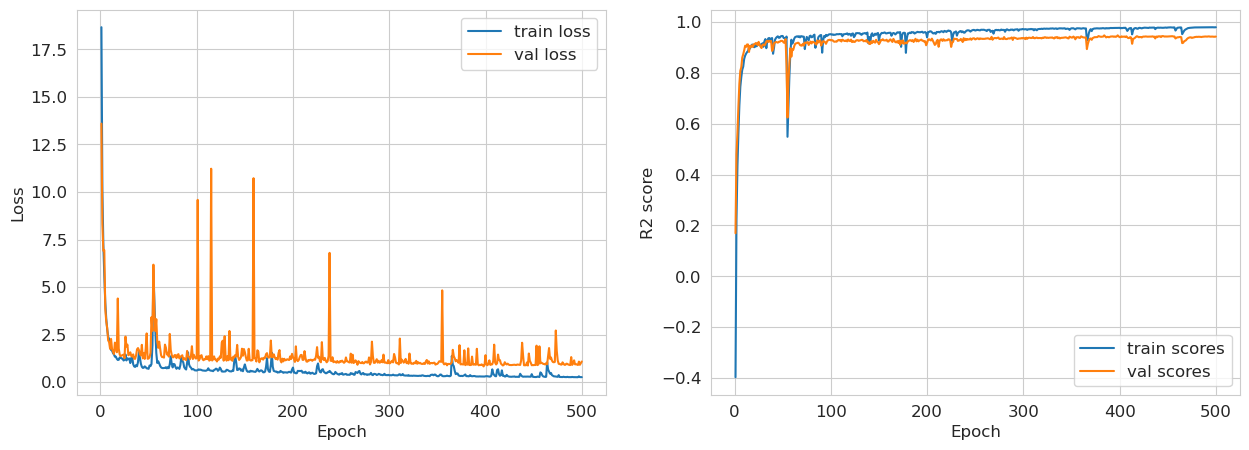

In [9]:
plot_history(train_losses, train_metric_scores, val_losses, val_metric_scores, start_ix=0, metric_name='R2 score')

Let's adjust the plot to focus on epochs 30 and beyond to provide a closer view of the loss/score values during training:

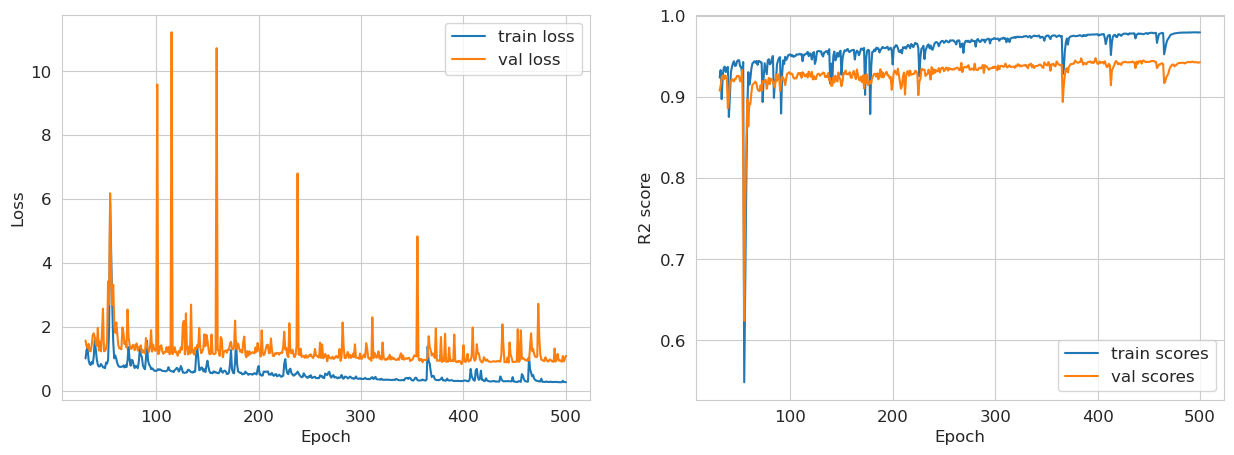

In [10]:
plot_history(train_losses, train_metric_scores, val_losses, val_metric_scores, start_ix=30, metric_name='R2 score')

Finally, let's create a scatter plot to visualize the true and predicted ΔG values and calculate the R2-score between them:

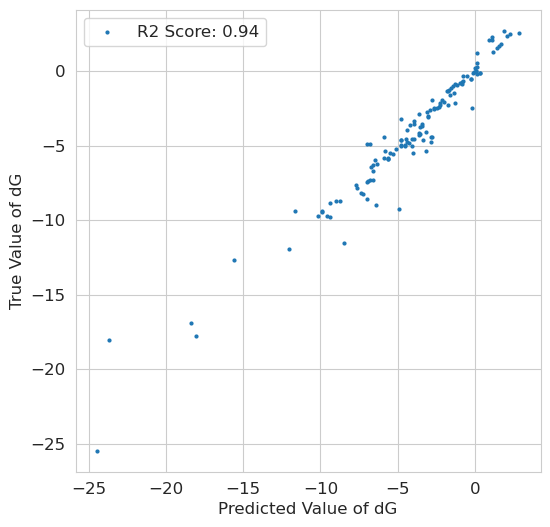

In [11]:
model.eval()
targets, preds = [], []

with torch.no_grad():
    for batch in test_loader:
        encoded_atoms, edges, natoms, dGsolv = batch
        encoded_atoms, edges = encoded_atoms.to(device), edges.to(device)

        dGsolv_pred = model(encoded_atoms, edges, natoms)
        targets.extend(dGsolv.tolist())
        preds.extend(dGsolv_pred.cpu().detach().tolist())
        
plt.figure(figsize=(6,6))
plt.scatter(preds, targets, s=4, label=f'R2 Score: {r2_score(targets, preds):.2f}')
plt.ylabel("True Value of dG")
plt.xlabel("Predicted Value of dG")
plt.legend()
plt.show()

As we can see from the plots depicted above, the predicted values display a strong correlation with the true values indicated by an R2-score of 0.94 (with a range of 0.88-0.96 for different random_states). Surprisingly, despite a gradual decrease in loss throughout training, there were occasional spikes in loss/scores, suggesting potential instability in the model's architecture or, alternatively, this phenomenon could be attributed to the limited size of the dataset (only 642 molecules for both training and validation).

At its current stage, this model is relatively simple using only atom types obtained from force field parameterization without incorporating any additional features. To enhance its performance, future steps may involve (i) integrating more features into the model such as AM1-BCC charges of atoms, bond types, and physicochemical descriptors obtained with rdkit, and (ii) exploring alternative methods for message passing (for example, using transformers for AGGREGATE) and extending message passing beyond immediate neighbors.

This model was primarily an experimental endeavor driven by curiosity and will serve as a foundational model for future explorations and experiments with GNNs.